In [1]:
import numpy as np
import pymc3 as pm
from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.data import Datasets
from pyei.plot_utils import tomography_plot

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [3]:
%load_ext autoreload
%autoreload 2

# Demo of 2x2 models and plotting using Santa Clara data

We show examples of using and examining models available in `pyei` using a sample data set:

In [4]:
data = Datasets.Santa_Clara.to_dataframe()
X = np.array(data["pct_e_asian_vote"])
T = np.array(data["pct_for_hardy2"])
N = np.array(data["total2"])
demographic_group_name = "e_asian"
candidate_name="Hardy"
precinct_names = data['precinct']
data.head()

,precinct,total_turnout,total2,pct_for_hardy2,pct_for_kolstad2,pct_for_nadeem2,total5,pct_for_caserta5,pct_not_caserta5,pct_for_lacoursiere5,...,pct_for_park5,pct_not_park5,pct_asian_vote,pct_asian_pop,pct_ind_vote,pct_ind_pop,pct_e_asian_vote,pct_e_asian_pop,pct_non_asian_vote,pct_non_asian_pop
0,4201,712,658,0.246201,0.431611,0.322188,642,0.447041,0.552960,0.305296,...,0.247664,0.752336,0.054775,0.117369,0.008427,0.028632,0.046348,0.088736,0.945225,0.882631
1,4208,400,380,0.328947,0.431579,0.239474,379,0.456464,0.543536,0.192612,...,0.350923,0.649076,0.197500,0.214389,0.060000,0.075990,0.137500,0.138399,0.802500,0.785611
2,4211,609,549,0.251366,0.384335,0.364299,542,0.492620,0.507380,0.250922,...,0.256458,0.743542,0.123153,0.202214,0.042693,0.046066,0.080460,0.156147,0.876847,0.797786
3,4215,623,573,0.258290,0.371728,0.369982,558,0.431900,0.568100,0.344086,...,0.224014,0.775986,0.109149,0.162014,0.032103,0.040379,0.077047,0.121635,0.890851,0.837986
4,4217,399,359,0.281337,0.406685,0.311978,355,0.425352,0.574648,0.326761,...,0.247887,0.752113,0.142857,0.254478,0.027569,0.063619,0.115288,0.190859,0.857143,0.745522


<AxesSubplot:xlabel='voter pref of e_asian for Hardy', ylabel='voter pref of non-e_asian for Hardy'>

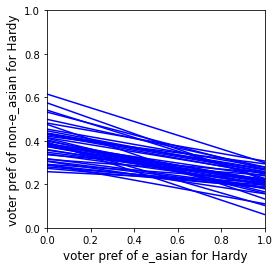

In [5]:
tomography_plot(X,T, demographic_group_name, candidate_name)

## Fitting a modified model from King 1999

This model uses different priors than from King '99: Pareto and uniform hyperparameters are used to perform partial pooling over beta distributions for the groups. The likelihood is the same (binomial) distribution. See, for example [Hierarchical Partial Pooling for Repeated Binary Trials](https://mc-stan.org/rstanarm/articles/pooling.html) for details of this prior structure.

In [6]:
ei = TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=8, pareto_shape=2)
ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name, precinct_names=precinct_names)
print(ei.summary())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_2, b_1, kappa_2, phi_2, kappa_1, phi_1]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 98 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e_asian for Hardy is
        0.800
        The posterior mean for the district-level voting preference of
        non-e_asian for Hardy is
        0.246
        95% Bayesian credible interval for district-level voting preference of
        e_asian for Hardy is
        [0.60156597 0.94427618]
        95% Bayesian credible interval for district-level voting preference of
        non-e_asian for Hardy is
        [0.22060723 0.27910368]
        


We can also pass to the fit() function additional keyword arguments for the sampler, such as:

- draws - the number of samples to draw
- chains - the number of chains
- tune - number of iteration to tune
- cores - number of chains to run in parallel

(see https://docs.pymc.io/api/inference.html sampling.sample for more)
E.g.:

In [7]:
ei = TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=8, pareto_shape=2)
ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name, precinct_names=precinct_names, draws=1200, tune=3000, target_accept=.99)
print(ei.summary())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_2, b_1, kappa_2, phi_2, kappa_1, phi_1]


Sampling 4 chains for 3_000 tune and 1_200 draw iterations (12_000 + 4_800 draws total) took 139 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e_asian for Hardy is
        0.807
        The posterior mean for the district-level voting preference of
        non-e_asian for Hardy is
        0.245
        95% Bayesian credible interval for district-level voting preference of
        e_asian for Hardy is
        [0.63274719 0.94673416]
        95% Bayesian credible interval for district-level voting preference of
        non-e_asian for Hardy is
        [0.21998605 0.27395395]
        


### Plotting features for this and any model involving posterior samples:

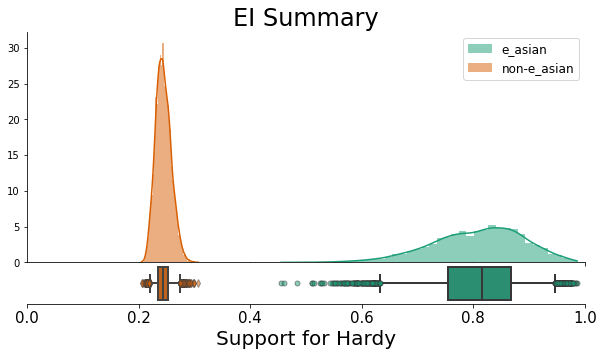

In [8]:
ax = ei.plot()

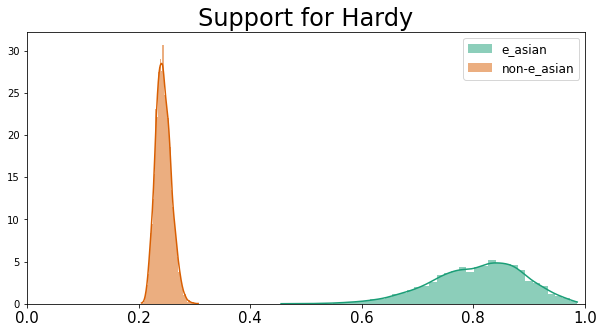

In [9]:
ax = ei.plot_kde()

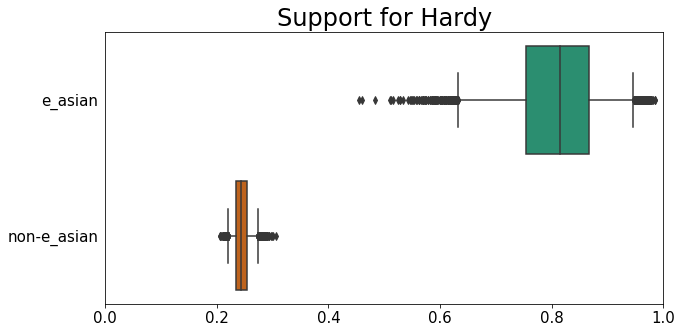

In [10]:
ax = ei.plot_boxplot()

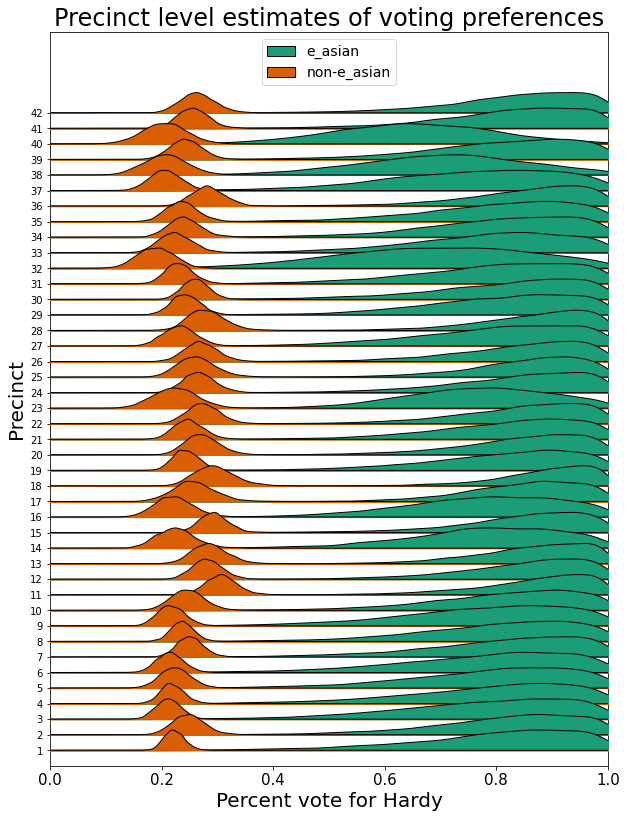

In [11]:
ax = ei.precinct_level_plot()

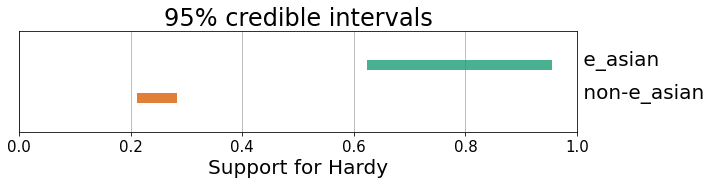

In [12]:
ax = ei.plot_intervals()

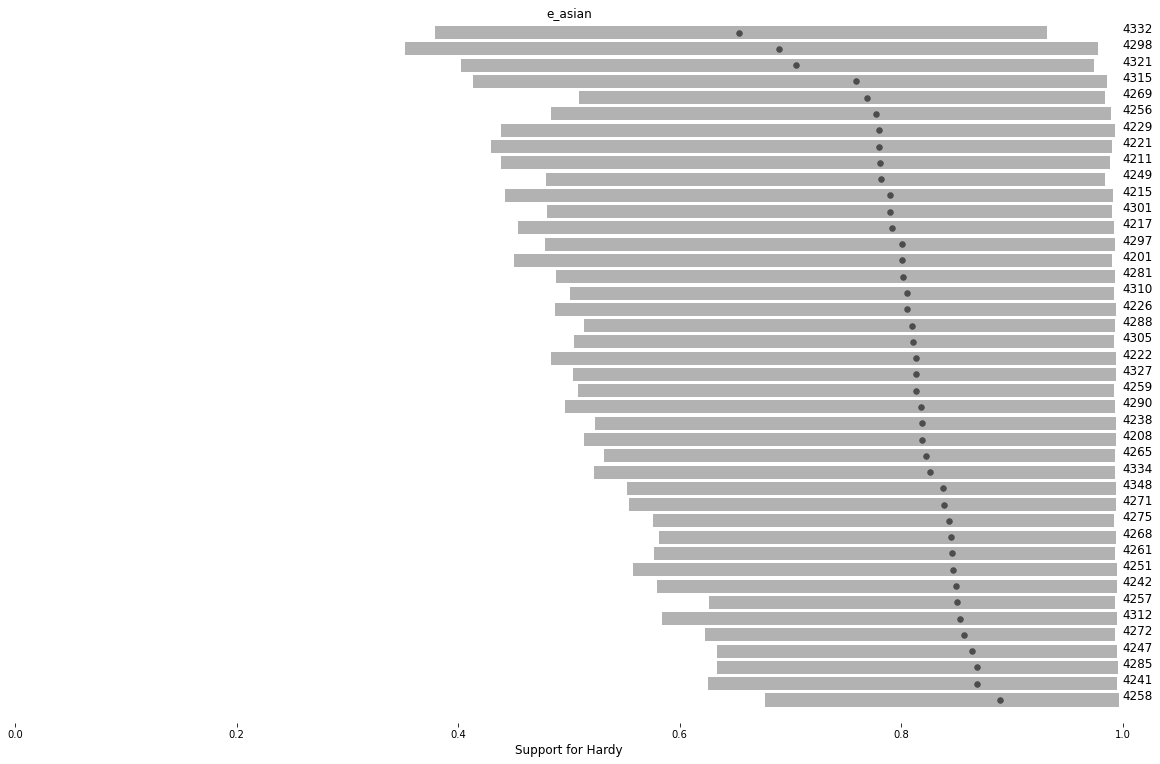

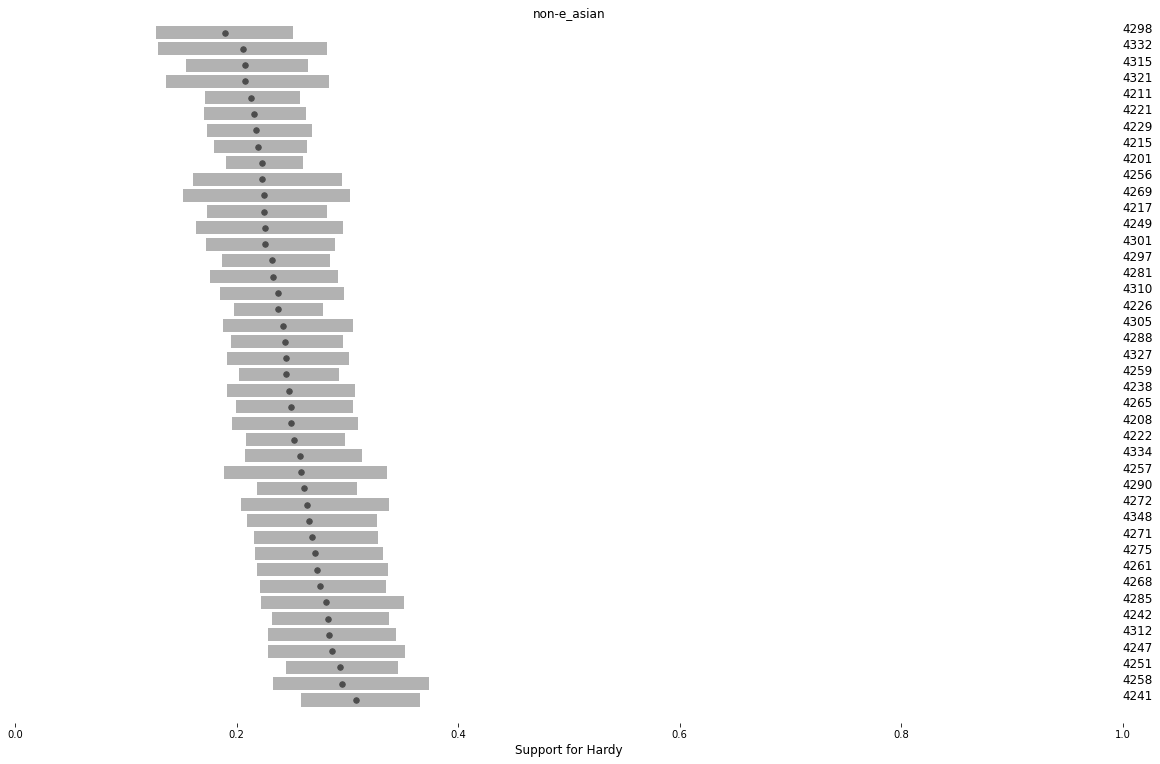

In [13]:
e_asian_ax, non_e_asian_ax = ei.plot_intervals_by_precinct()

### Examine polarization / differences between groups' voting preferences

### a) probability that the difference is above a certain threshold

In [14]:
ei.polarization_report(threshold=0.4)

There is a 94.6% probability that the difference between the groups' preferences for Hardy (e_asian -  non-e_asian) is more than 0.40.


94.5625

In [15]:
ei.polarization_report(threshold=-0.4, reference_group=1)

There is a 5.4% probability that the difference between the groups' preferences for Hardy (non-e_asian -  e_asian) is more than -0.40.


5.4375

In [16]:
ei.polarization_report(threshold=0.4, verbose=False)

94.5625

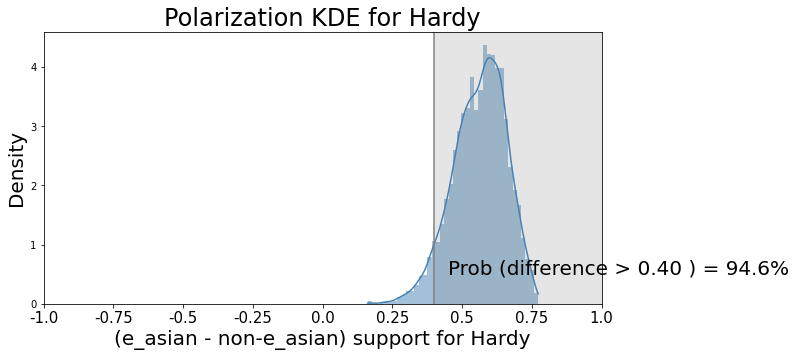

In [17]:
ax = ei.plot_polarization_kde(threshold=0.4, show_threshold=True) #set show_threshold to false to just view the kde

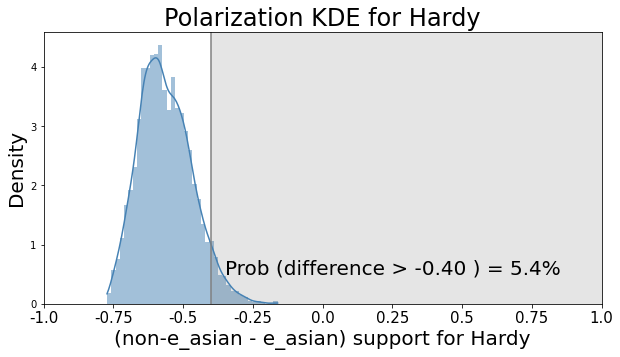

In [18]:
ax = ei.plot_polarization_kde(threshold=-0.4, show_threshold=True, reference_group=1)

### b) find threshold for a desired probability level

In [19]:
ei.polarization_report(percentile=95, verbose=True)

There is a 95% probability that the difference between the groups' preferences for Hardy (e_asian - non-e_asian) is between [0.36, 0.72].


(0.3590286420098186, 0.7249744514556091)

In [20]:
ei.polarization_report(percentile=95, verbose=True, reference_group=1)

There is a 95% probability that the difference between the groups' preferences for Hardy (non-e_asian - e_asian) is between [-0.72, -0.36].


(-0.7249744514556091, -0.3590286420098188)

In [21]:
ei.polarization_report(percentile=95, verbose=False)

(0.3590286420098186, 0.7249744514556091)

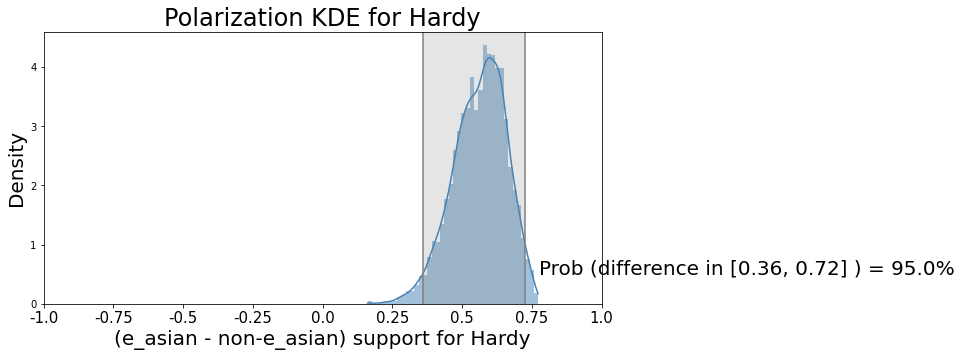

In [22]:
ax = ei.plot_polarization_kde(percentile=95, show_threshold=True)

## Summary features

In [23]:
print(ei.summary())

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e_asian for Hardy is
        0.807
        The posterior mean for the district-level voting preference of
        non-e_asian for Hardy is
        0.245
        95% Bayesian credible interval for district-level voting preference of
        e_asian for Hardy is
        [0.63274719 0.94673416]
        95% Bayesian credible interval for district-level voting preference of
        non-e_asian for Hardy is
        [0.21998605 0.27395395]
        


### Posterior mean for district-wide voting preferences (mean of [precinct samples weighted by population]):

In [24]:
posterior_mean_voting_prefs =ei.posterior_mean_voting_prefs
print(demographic_group_name, " support for ", candidate_name, posterior_mean_voting_prefs[0])
print("non-",demographic_group_name, " support for ", candidate_name, posterior_mean_voting_prefs[1])


e_asian  support for  Hardy 0.8073316204192923
non- e_asian  support for  Hardy 0.2445344358588772


### 95% credible intervals

In [25]:
credible_interval_95_mean_voting_prefs = ei.credible_interval_95_mean_voting_prefs
print(demographic_group_name, " support for ", candidate_name, credible_interval_95_mean_voting_prefs[0])
print("non-",demographic_group_name, " support for ", candidate_name, credible_interval_95_mean_voting_prefs[1])


e_asian  support for  Hardy [0.63274719 0.94673416]
non- e_asian  support for  Hardy [0.21998605 0.27395395]


### Precinct-level posterior means and credible intervals

In [26]:
precinct_posterior_means, precinct_credible_intervals = ei.precinct_level_estimates()
#precinct_posterior_means has shape num_precincts x 2 (groups) x 2 (candidates)
print(precinct_posterior_means[5][0][0]) # Estimated (posterior mean) support for the candidate from the group in precinct 5
#precinct_credible_intervals has shape num_precincts x 2 (groups) x 2 (candidates) x 2 (endpoints))
print(precinct_credible_intervals[5][0][0]) # 95% credible interval of support for the candidate from the group in precint 5

0.7804966288576903
[0.429621   0.99051069]


## Accessing samples

Samples from the posterior distribution of district-wide voter preferences (calculated by weighting each set of precinct-level samples by the population and summing):

In [27]:
sampled_voting_prefs = ei.sampled_voting_prefs # ei.sampled_voting_prefs is samples of district-level voter preference: list of length 2
sampled_voting_prefs[0] #samples of district-wide support of specified group for specified candidate
sampled_voting_prefs[1] #samples of district-wide support of (complement of specified group) for specified candidate
sampled_voting_prefs[0].mean() #posterior mean
sampled_voting_prefs[1].mean() #posterior mean

0.2445344358588772

Precinct level samples of voting preferences:

In [28]:
precinct_num_of_interest = 5
ei.sim_trace["b_1"].shape # num_samples x num_precincts
print("calculate posterior mean for voter preference of ", demographic_group_name, " for ", candidate_name," in precinct ",precinct_num_of_interest )
ei.sim_trace["b_1"][:, precinct_num_of_interest].mean() 

calculate posterior mean for voter preference of  e_asian  for  Hardy  in precinct  5


0.7804966288576897

Posterior samples for hyperparameters are also accessible.

In [29]:
ei.sim_trace["kappa_1"].shape 

(4800,)

## Accessing and visualizing the pymc the model

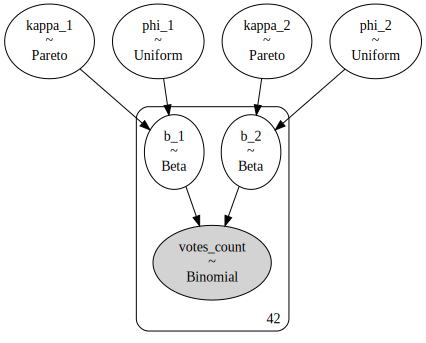

In [30]:
model = ei.sim_model
pm.model_to_graphviz(model)

## Fitting the model from King 1999

This is a faithful representation of the model from King '99: all of the hyperparameters are exponentially distributed with a fixed lambda value. 

In [31]:
ei = TwoByTwoEI(
    "king99", lmbda=0.1
)  # king uses 0.5, but smaller lambdas seem more stable
ei.fit(X, T, N, demographic_group_name="e asian", candidate_name="Hardy")
print(ei.summary())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_2, b_1, d_2, c_2, d_1, c_1]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 92 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Model: king99
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e asian for Hardy is
        0.813
        The posterior mean for the district-level voting preference of
        non-e asian for Hardy is
        0.244
        95% Bayesian credible interval for district-level voting preference of
        e asian for Hardy is
        [0.5842304  0.96420326]
        95% Bayesian credible interval for district-level voting preference of
        non-e asian for Hardy is
        [0.21730146 0.28175929]
        


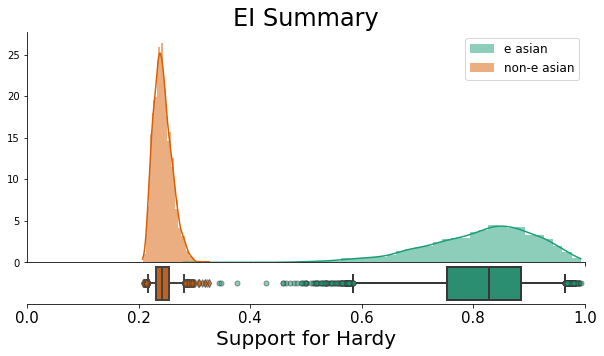

In [32]:
ei.plot();

<AxesSubplot:title={'center':'Precinct level estimates of voting preferences'}, xlabel='Percent vote for Hardy', ylabel='Precinct'>

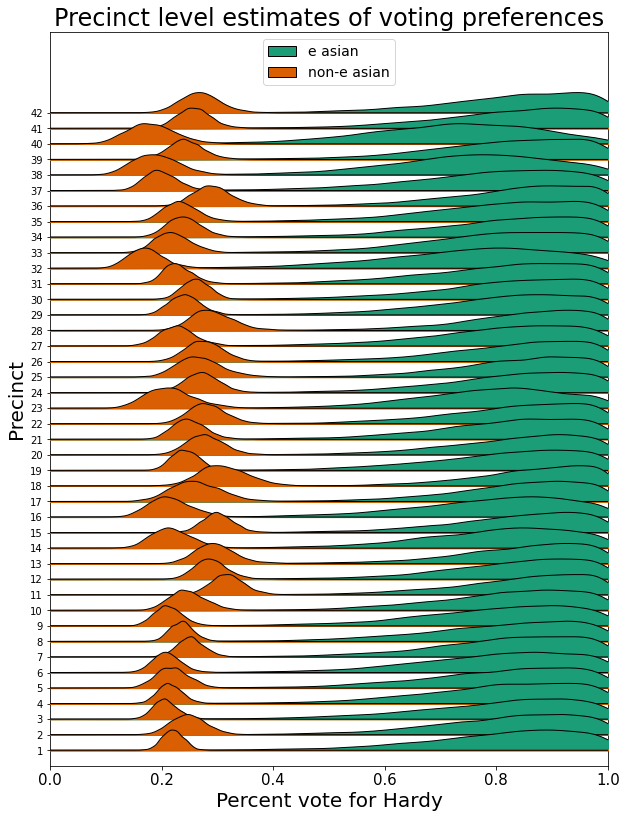

In [33]:
ei.precinct_level_plot()

## Fitting the model(s) from Wakefield 2004

(UNDER DEVELOPMENT)

In [34]:
ei = TwoByTwoEI(model_name="wakefield_beta")
ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name, precinct_names=precinct_names)
print(ei.summary())

INFO (theano.gof.compilelock): Waiting for existing lock by process '95515' (I am process '94536')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/gabe/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.10-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_2, b_1, kappa_2, phi_2, kappa_1, phi_1]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 461 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Model: wakefield_beta
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e_asian for Hardy is
        0.799
        The posterior mean for the district-level voting preference of
        non-e_asian for Hardy is
        0.249
        95% Bayesian credible interval for district-level voting preference of
        e_asian for Hardy is
        [0.59902088 0.93167382]
        95% Bayesian credible interval for district-level voting preference of
        non-e_asian for Hardy is
        [0.22582291 0.28166744]
        


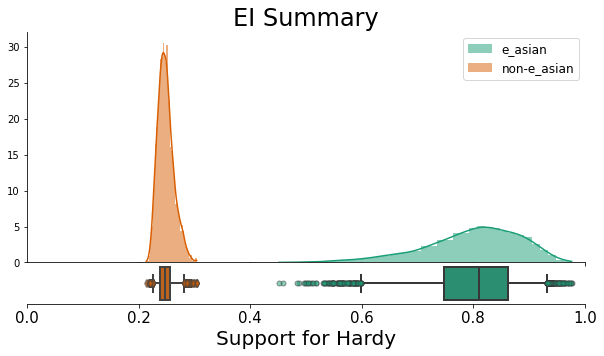

In [35]:
ei.plot();

<AxesSubplot:title={'center':'Precinct level estimates of voting preferences'}, xlabel='Percent vote for Hardy', ylabel='Precinct'>

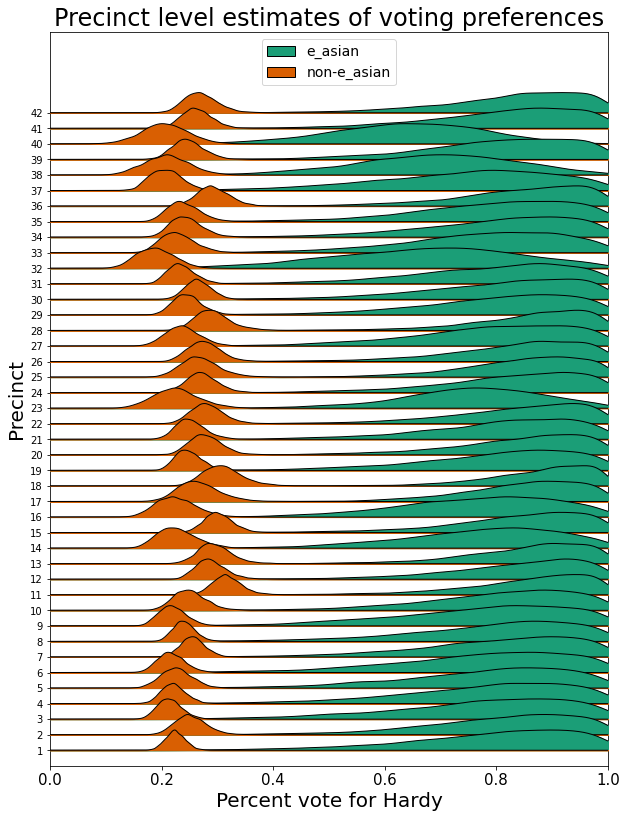

In [36]:
ei.precinct_level_plot()

In [37]:
# UNDER DEVELOPMENT
ei = TwoByTwoEI(model_name="wakefield_normal", mu0=0, mu1=0)
ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name, precinct_names=precinct_names)
print(ei.summary())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta0, sigma1, sigma0]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 2740 seconds.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9425529655578587, but should be close to 0.99. Try to increase the number of tuning steps.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.


Model: wakefield_normal
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e_asian for Hardy is
        0.452
        The posterior mean for the district-level voting preference of
        non-e_asian for Hardy is
        0.311
        95% Bayesian credible interval for district-level voting preference of
        e_asian for Hardy is
        [0.29850167 0.53665327]
        95% Bayesian credible interval for district-level voting preference of
        non-e_asian for Hardy is
        [0.29383646 0.33889495]
        


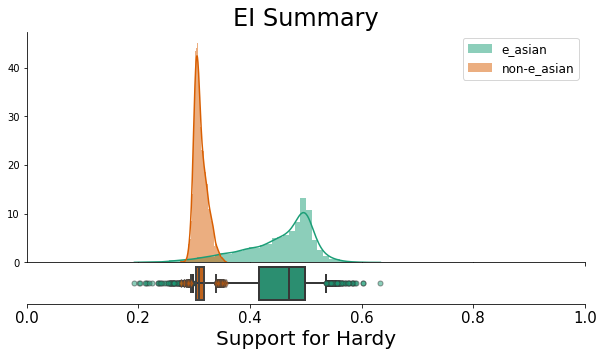

In [38]:
ei.plot();

## Fitting Goodman's ecological regression

In [39]:
goodmans_er = GoodmansER().fit(
    X, T, demographic_group_name="e asian", candidate_name="Hardy"
)
print(goodmans_er.summary())

Goodmans ER
        Est. fraction of e asian
        voters who voted for Hardy is
        0.862
        Est. fraction of non- e asian
        voters who voted for Hardy is
        0.239
        


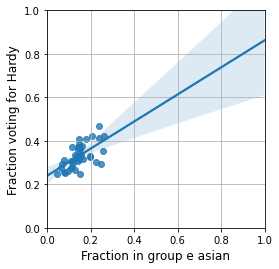

In [40]:
goodmans_er.plot();

## Fitting a weighted version of Goodman's ecological regression

In [41]:
goodmans_er = GoodmansER(is_weighted_regression="True")
goodmans_er.fit(X, T, N, demographic_group_name="e asian", candidate_name="Hardy")
print(goodmans_er.summary())

Goodmans ER, weighted by population
        Est. fraction of e asian
        voters who voted for Hardy is
        0.865
        Est. fraction of non- e asian
        voters who voted for Hardy is
        0.236
        


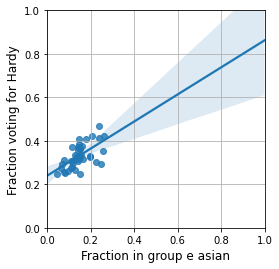

In [42]:
goodmans_er.plot();

## Fitting a Bayesian version of Goodman's ecological regression

With uniform \[0,1\] priors over the voting preferences for each group. Options to weigh the precints based on population or not.

In [43]:
bayes_goodman_ei = GoodmansERBayes("goodman_er_bayes", weighted_by_pop=True, sigma=1)
bayes_goodman_ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name)
print(bayes_goodman_ei.summary())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b_2, b_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


Model: goodman_er_bayes
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e_asian for Hardy is
        0.838
        The posterior mean for the district-level voting preference of
        non-e_asian for Hardy is
        0.240
        95% Bayesian credible interval for district-level voting preference of
        e_asian for Hardy is
        [0.63589697 0.98360276]
        95% Bayesian credible interval for district-level voting preference of
        non-e_asian for Hardy is
        [0.21125192 0.27743138]
        


<AxesSubplot:title={'center':'Support for Hardy'}>

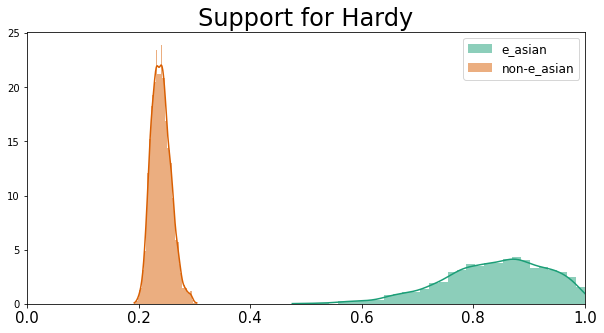

In [44]:
bayes_goodman_ei.plot_kde()

In [45]:
 x_vals, means, lower_bounds, upper_bounds = bayes_goodman_ei.compute_credible_int_for_line()

In [46]:
import arviz as az
idata = az.from_pymc3(bayes_goodman_ei.sim_trace, model=bayes_goodman_ei.sim_model)

In [47]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [48]:
idata.sample_stats.diverging

<xarray.DataArray 'diverging' (chain: 4, draw: 1000)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [49]:
az.stats.rhat(idata)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    b_1      float64 1.004
    b_2      float64 1.003
    eps      float64 1.003